# Advanced QROM (aka QROAM) using clean ancilla

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `QROMBase`
Interface for Bloqs to load `data[l]` when the selection register stores index `l`.

## Overview
The action of a QROM can be described as
$$
        \text{QROM}_{s_1, s_2, \dots, s_K}^{d_1, d_2, \dots, d_L}
        |s_1\rangle |s_2\rangle \dots |s_K\rangle
        |0\rangle^{\otimes b_1} |0\rangle^{\otimes b_2} \dots |0\rangle^{\otimes b_L}
        \rightarrow
        |s_1\rangle |s_2\rangle \dots |s_K\rangle
        |d_1[s_1, s_2, \dots, s_k]\rangle
        |d_2[s_1, s_2, \dots, s_k]\rangle \dots
        |d_L[s_1, s_2, \dots, s_k]\rangle
$$

A behavior of a QROM can be understood in terms of its classical analogue, where a for-loop
over one or more (selection) indices can be used to load one or more classical datasets, where
each of the classical dataset can be multidimensional.

```
>>> # N, M, P, Q, R, S, T are pre-initialized integer parameters.
>>> output = [np.zeros((P, Q)), np.zeros((R, S, T))]
>>> # Load two different classical datasets; each of different shape.
>>> data = [np.random.rand(N, M, P, Q), np.random.rand(N, M, R, S, T)]
>>> for i in range(N): # For loop over two selection indices i and j.
>>>     for j in range(M):
>>>        # Load two multidimensional classical datasets data[0] and data[1] s.t.
>>>        # |i, j⟩|0⟩  -> |i, j⟩|data[0][i, j, :]⟩|data[1][i, j, :]⟩
>>>        output[0] = data[0][i, j, :]
>>>        output[1] = data[1][i, j, :]
```

The parameters that control the behavior and costs of a QROM are -

1. Number of selection registers (eg: $i$, $j$) and their iteration lengths (eg: $N$, $M$).
2. Number of target registers, their quantum datatype and shape.
    - Number of target registers: One for each classical dataset to load (eg: $\text{data}[0]$
        and $\text{data}[1]$)
    - QDType of target registers: Depends on `dtype` of the $i$'th classical dataset
    - Shape of target registers: Depends on shape of classical data (eg: $(P, Q)$ and
        $(R, S, T)$ above)

### Specification of classical data via `data_or_shape`
Users can specify the classical data to load via QROM by passing in an appropriate value
for `data_or_shape` attribute. This is a list of numpy arrays or `Shaped` objects, where
each item of the list corresponds to a classical dataset to load.

Each classical dataset to load can be specified as a numpy array (or a `Shaped` object for
symbolic bloqs). The shape of the dataset is a union of the selection shape and target shape,
s.t.
$$
    \text{data[i].shape} = \text{selection\_shape} + \text{target\_shape[i]}
$$

Note that the $\text{selection\_shape}$ should be same across all classical datasets to be
loaded and correspond to a tuple of iteration lengths of selection indices (i.e. $(N, M)$
in the example above).

The target shape of each classical dataset can be different and parameterizes the size of
the desired output that should be loaded in a target register.

### Number of selection registers and their iteration lengths
As describe in the previous section, the number of selection registers and their iteration
lengths can be inferred from the shape of the classical dataset. All classical datasets
to be loaded must have the same $\text{selection\_shape}$, which is a tuple of iteration
lengths over each dimension of the dataset (i.e. the range for each nested for-loop).

In order to load a data set with $\text{selection\_shape} == (P, Q, R, S)$ the QROM bloq
needs four selection registers with bitsizes $(p, q, r, s)$ where each of
$p,q,r,s \geq \log_2{P}, \log_2{Q}, \log_2{R}, \log_2{S}$.

In general, to load $K$ dimensional data, we use $K$ named selection registers
$(\text{selection}_0, \text{selection}_1, ..., \text{selection}_k)$ to index and
load the data. For the $i$'th selection register, its size is configured using
attribute $\text{selection\_bitsizes[i]}$ and the iteration range is configued
using $\text{data\_or\_shape[0].shape[i]}$.

### Number of target registers, their quantum datatype and shape
QROM bloq uses one target register for each entry corresponding to classical dataset in the
tuple `data_or_shape`. Thus, to load $L$ classical datsets, we use $L$ names target registers
$(\text{target}_0, \text{target}_1, ..., \text{target}_L)$

Each named target register has a bitsize $b_{i}=\text{target\_bitsizes[i]}$ that represents
the size of the register and depends upon the maximum value of individual elements in the
$i$'th classical dataset.

Each named target register has a shape that can be configured using attribute
$\text{target\_shape[i]}$ that represents the number of target registers if the output to load
is multidimensional.

#### Parameters
 - `data_or_shape`: List of numpy ndarrays specifying the data to load. If the length of this list ($L$) is greater than one then we use the same selection indices to load each dataset. The shape of a classical dataset is a concatenation of selection_shape and target_shape[i]; i.e. `data_or_shape[i].shape = selection_shape + target_shape[i]`. Thus, each data set is required to have the same selection shape $(S_1, S_2, ..., S_K)$ and can have a different target shape given by `target_shapes[i]`. For symbolic QROMs, pass a list of `Shaped` objects instead with shape $(S_1, S_2, ..., S_K) + target_shape[i]$.
 - `selection_bitsizes`: The number of bits used to represent each selection register corresponding to the size of each dimension of the selection_shape $(S_1, S_2, ..., S_K)$. Should be the same length as the selection shape of each of the datasets and $2**\text{selection\_bitsizes[i]} >= S_i$
 - `target_shapes`: Shape of target registers for each classical dataset to be loaded. Must be consistent with `data_or_shape` s.t. `len(data_or_shape) == len(target_shapes)` and `data_or_shape[-len(target_shapes[i]):] == target_shapes[i]`.
 - `target_bitsizes`: Bitsize (or qdtype) of the target registers for each classical dataset to be loaded. This can be deduced from the maximum element of each of the datasets. Must be consistent with `data_or_shape` s.t. `len(data_or_shape) == len(target_bitsizes)` and `target_bitsizes[i] >= max(data[i]).bitsize`.
 - `num_controls`: The number of controls to instanstiate a controlled version of this bloq.


## `QROAMClean`
Lower cost variant of SelectSwapQROM. Assumes target register is initially in |0> state.

To load a classical dataset of $N$ elements, each of bitsize $b$, into a target register initialized
in the $|0\rangle$ state, this construction uses:
    - $\frac{N}{K} + (K - 1) \times b$ Toffoli gates.
    - $(K - 1)$ ancilla registers, each of bitsize $b$, left in a junk state and should be kept
     around to get uncomputed by the adjoint bloq - `QROAMCleanAdjoint`.

Here $K=2^k$ is a configurable constant and should be set to $\sqrt{\frac{N}{b}}$ for optimal cost.

Similar to SelectSwapQROM, this bloq also supports loading multiple classical datasets,
each of which can be multidimensional. Factory methods `QROAMClean.build_from_data` and
`QROAMClean.build_from_bitsize` should be used to construct the bloq.

The adjoint of the bloq is performed via `QROAMCleanAdjoint`, and reduces to a problem of
uncomputing a table lookup with $N$ elements, each of target bitsize $K \times b$. The data to
be loaded for uncomputation is computed by this bloq in the `self.batched_data_permuted`
property.

`QROAMCleanAdjoint` uses measurement based uncomputation to uncompute a table lookup of $N$
elements and target bitsize $b$ using only $\frac{N}{K} + (K - 1)$ Toffoli gates
(instead of $\frac{N}{K} + (K - 1) \times b$ used by the original lookup). Thus, increasing the
target bitsize for uncomputation is preferred since complexity of uncomputation does not depend
upon the target bitsize of elements to be loaded.

#### Registers
 - `- control_registers`: If control is specified, a THRU register to denote the control qubits. Empty by default for uncontrolled version of the Bloq.
 - `- selection_registers`: $N$ THRU registers, each with shape (), to load $N$ dimensional classical datasets.
 - `- target_registers`: $M$ RIGHT registers to load $M$ different classical datasets. Each target register is of bitsize $b$ and shape described by a tuple of length $N$.
 - `- junk_registers`: $K - 1$ RIGHT registers, each of bitsize $b$ used to load batches of size $K$ 

#### References
 - [Qubitization of Arbitrary Basis Quantum Chemistry Leveraging Sparsity and Low Rank Factorization](https://arxiv.org/abs/1902.02134).     Berry et al. (2019). Appendix A. and B.


In [2]:
from qualtran.bloqs.data_loading.qroam_clean import QROAMClean

### Example Instances

In [3]:
data1 = np.arange(5, dtype=int)
data2 = np.arange(5, dtype=int) + 1
qroam_clean_multi_data = QROAMClean.build_from_data(data1, data2, log_block_sizes=(1,))

In [4]:
data1 = np.arange(25, dtype=int).reshape((5, 5))
data2 = (np.arange(25, dtype=int) + 1).reshape((5, 5))
qroam_clean_multi_dim = QROAMClean.build_from_data(data1, data2, log_block_sizes=(1, 1))

In [5]:
N, b, k, c = sympy.symbols('N b k c')
qroam_clean_symb_1d = QROAMClean.build_from_bitsize(
    (N,), (b,), log_block_sizes=(k,), num_controls=c
)

In [6]:
N, M, b1, b2, k1, k2, c = sympy.symbols('N M b1 b2 k1 k2 c')
log_block_sizes = (k1, k2)
qroam_clean_symb_2d = QROAMClean.build_from_bitsize(
    (N, M), (b1, b2), log_block_sizes=log_block_sizes, num_controls=c
)

#### Graphical Signature

In [7]:
from qualtran.drawing import show_bloqs
show_bloqs([qroam_clean_multi_data, qroam_clean_multi_dim],
           ['`qroam_clean_multi_data`', '`qroam_clean_multi_dim`'])

### Call Graph

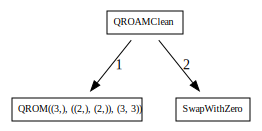

#### Counts totals:
 - `QROM((3,), ((2,), (2,)), (3, 3))`: 1
 - `SwapWithZero`: 2

In [8]:
from qualtran.resource_counting.generalizers import ignore_split_join
qroam_clean_multi_data_g, qroam_clean_multi_data_sigma = qroam_clean_multi_data.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(qroam_clean_multi_data_g)
show_counts_sigma(qroam_clean_multi_data_sigma)